# 1. Understanding the data

As always, the first step in any data analysis pipeline is to understand what you're looking at.

Inspection reveals a few points of interest:
1. Age is not an integer value (i.e. we can have a 50.5 year old)
2. Age and Cabin contains missing data (Cabin also contains partial data, e.g. C rather than C01)
3. Multiple numeric variables are not Guassian (e.g. age and fare)

Also, because we have the train and test data, we can also check for drift in the input parameters for any model we might build.

## 1.1. General Background

It is important to appreciate that this data was obviously not collected in a well-controlled experiment. From a scientific perspective, this is important in shaping how we think about features and interpret missing data (chapter 2).


In [1]:
%matplotlib inline

from pathlib import Path

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.rcParams.update({'font.size': 8})

In [125]:
data_dir = Path.cwd().parent.parent / 'data/titanic'

train = pd.read_csv(data_dir / 'train.csv')
test = pd.read_csv(data_dir / 'test.csv')

train.columns
test['Age'].isna().mean()

0.20574162679425836

## 1.2. Thinking about the features

### Age

When analysing data like the titanic dataset, we have intuitions about how the data should look. For example, we wouldn't expect negative values for age. For this reason, we might also expect that the distribution of age may not be gaussian. In fact, let's look at that now: 

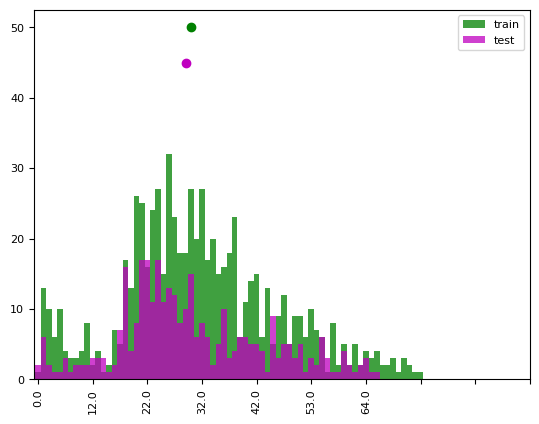

In [3]:
# Describe as years old
train['YrsOld'] = train['Age'].round()
test['YrsOld'] = test['Age'].round()

# Plot distributions for train and test datasets
fig, ax = plt.subplots(1,1)

train['YrsOld'].value_counts().sort_index().plot.bar(
    ax=ax, **{'color':'g','alpha':0.75, 'width':1,'label':'train','lw':0})

test['YrsOld'].value_counts().sort_index().plot.bar(
    ax=ax, **{'color':'m','alpha':0.75, 'width':1,'label':'test','lw':0})

plt.scatter( x=train['YrsOld'].median(), y=50, color='g')
plt.scatter( x=test['YrsOld'].median(), y=45, color='m')

plt.xticks(list(range(0,100,10)))
plt.legend()
plt.show()

We can see that ages in train and test datasets:

- are not normally distributed
- overlap, but show subtle differences: passengers in the test dataset are generally younger (median = 28 vs 27)

We would expect children to be more likely to be saved than adults (as they're prioritised and because you can fit more children than adults in a lifeboat), but is this true?

For this analysis, we're going to discover that rounding age to a single year gives noisy data - particularly when some ages have only one or two datapoints. It's therefore useful to round ages into age groups.

In [4]:
def round_to_agegroup(x, interval=5):
    return (np.floor(x / interval) * interval) + (interval/2)

train['age_group'] = train['Age'].apply(round_to_agegroup)

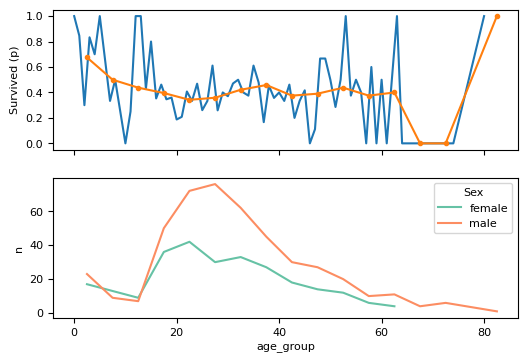

In [51]:
fig, axs = plt.subplots(2,1, sharex=True, **{'figsize':(6,4)})

train.groupby('YrsOld')['Survived'].mean().plot(ax=axs[0])
train.groupby('age_group')['Survived'].mean().plot(ax=axs[0], **{'marker':'.'})
axs[0].set_ylabel('Survived (p)')

sns.lineplot(
    data = pd.DataFrame(train.groupby(['Sex','age_group'])['class'].count()),
    y = 'class',
    x = 'age_group',
    hue = 'Sex',
    palette = 'Set2'
)
axs[1].set_ylabel('n')

plt.show()

The top plot above shows that very young children do indeed have the best survival rates, but this benifit is lost by the time we reach ages 10-15. This highlights how the definition of concepts (e.g. childhood) is culturally and temporally specific.

Looking at the age profile for men and women also reveals that children were drawn from equal demographics, whereas from the mid-teens up until the sixties, the skew is for there to be more men. 

### Gender

We might expect women to survive more often than men. Is this true? Also, this difference between genders is unlikely to be felt for children, and so does any effect of gender vary with age? 

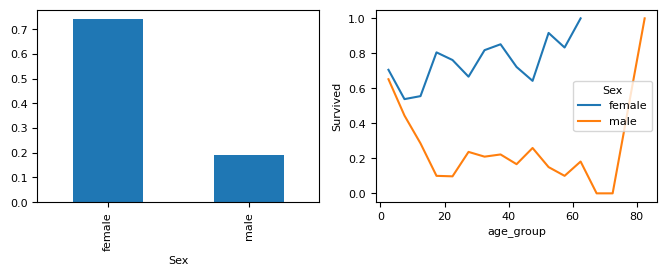

In [6]:
fig, axs = plt.subplots(1,2, **{'figsize':(8,2.5)})

train.groupby('Sex')['Survived'].mean().plot.bar(ax=axs[0])

sns.lineplot(
    data = pd.DataFrame(train.groupby(['Sex','age_group'])['Survived'].mean()),
    x = 'age_group',
    y = 'Survived',
    hue = 'Sex',
    ax = axs[1]
)

plt.legend
plt.show()

We can see that gender has a huge effect on survival rates, and so we might do quite well at just guessing based on this (as is specified in the [dummy predictions](./../../data/titanic/gender_submission.csv)). However as we also predicted, there is a clear interaction between age and gender, with the gender of children under 5 less irrelevant and then age becoming more important in lowering the survival rates of men and not women (who's survival actually increases with age).

### Class & Fare

If access to lifeboats was affected by social status, we might also expect survival rates to vary with ticket class. The plots below confirm this, and also show an interaction with gender, where the biggest difference in survival between men and women was in second class.

Note that the initial data contains 'Pclass' as a continuous variable, whereas in reality it's a categorical variable. (Someone in third class is not equivalent to three first class passengers). We therefore add a cateogrical variable for our investigation. This will also be important in future if we apply statistical models that need to know whether numeric values follow mathematical rules (which these categories don't).

In [7]:
train['class'] = train['Pclass'].astype("category")
test['class'] = test['Pclass'].astype("category")

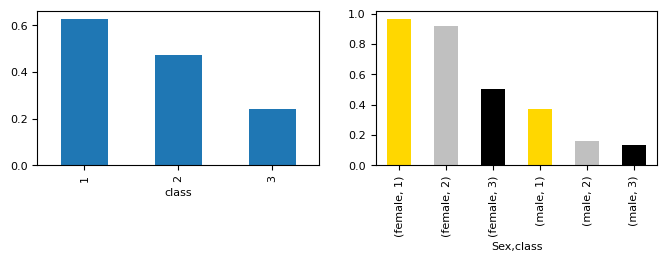

In [8]:
fig, axs = plt.subplots(1,2, **{'figsize':(8,2)})

train.groupby(by=['class'])['Survived'].mean().plot.bar(ax=axs[0])

survival_by_class_gender = train.groupby(by=['Sex','class'])['Survived'].mean()
survival_by_class_gender.plot.bar(color=['gold','silver','k'], ax=axs[1])

plt.show()

We might also expect some correlation between class of ticket and fare. We can show this using the correlation matrix between variables. Again to understand about the generality of the test and train datasets, we'll look at both sources that are available.

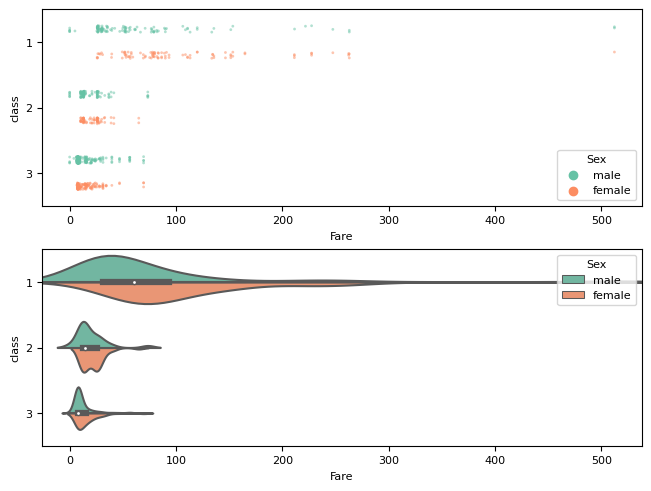

In [9]:
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(2,2)

ax_1 = sns.stripplot(
    data=train, 
    x="Fare", 
    y="class", 
    hue="Sex", 
    jitter = True,
    size = 2,
    palette = 'Set2',
    alpha = 0.5,
    dodge=True,
    ax = fig.add_subplot(gs[0,:])
    )


ax_2 = sns.violinplot(
    data=train, 
    x="Fare", 
    y="class", 
    hue="Sex", 
    split = True,
    palette = 'Set2',
    legend=False,
    ax = fig.add_subplot(gs[1,:])
    )


ax_2.set_xlim(ax_1.get_xlim())

plt.show()

So if class improves your chance of survival, presumably a more expensive ticket is associated with survival too? Let's find out. 

Here, we're going to repeat the grouping approach used for age groups, but here, we're going to use logarithmically spaced bins to account for the price structure being different.

In [80]:
def get_fare_group(x, log_interval=2):
    return log_interval ** np.floor(np.log(x+0.1) / np.log(log_interval))

train['fare_group'] = train['Fare'].apply(get_fare_group)

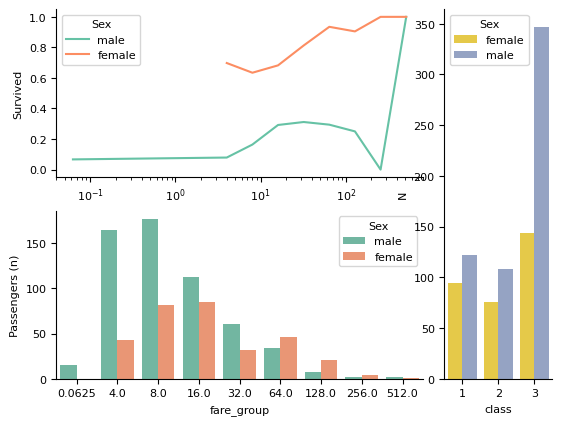

In [119]:
fare_group_samplesize = train.groupby(['fare_group','Sex'])['Survived'].count()
fare_group_survival = train.groupby(['fare_group','Sex'])['Survived'].mean()

fig = plt.figure()
gs = fig.add_gridspec(2,4)

ax_0 = sns.lineplot(
    data = pd.DataFrame(fare_group_survival).reset_index(),
    x = 'fare_group',
    y = 'Survived',
    hue = 'Sex',
    palette = 'Set2',
    ax = fig.add_subplot(gs[0,0:3])
)

ax_0.set_xscale('log')

ax_1 = sns.barplot(
    data = pd.DataFrame(fare_group_samplesize).reset_index(),
    x = 'fare_group',
    y = 'Survived',
    hue = 'Sex',
    palette = 'Set2',
    ax = fig.add_subplot(gs[1,0:3])
)

ax_1.set_ylabel('Passengers (n)')
# ax_1._legend.set_visible(False)

# Plot class of passengers by gender
count_by_class_gender = (
    pd.DataFrame(
        train[['class','Sex','Fare']]
        .groupby(['Sex','class'])
        .count()
    )
    .reset_index()
    .sort_values(by='Sex')
    .rename({'Fare':'N'}, axis=1)
)

ax_2 = sns.barplot(
    data = count_by_class_gender,
    x = 'class',
    y = 'N',
    hue = 'Sex',
    palette = 'Set2_r',
    ax = fig.add_subplot(gs[:,3])
)

sns.despine(ax=ax_0)
sns.despine(ax=ax_1)
sns.despine(ax=ax_2)

# ax_1.legend().remove()
# ax_2.legend().remove()
plt.show()

Yes, paying more increases your chances of survival - although only up to a point if you're a man. The demographics of fares also shows an interesting difference - the fare for a woman's ticket is on average more than a man's.  That makes sense if you consider that the gender ratio in first and second class is closer to parity, whereas a larger number of men in 3rd class are the driver for the lower fares. 

#### Cabin

Cabin is one of those variables that is difficult to manage; one generally expects there to be some relationship between cabin and other variables such as fare, class, or indeed to be indicative of connections between passengers. However the specific cabin arrangement is specific to the ship, and many datapoints are missing. Here's what we can glean from the available data:

1st class: Sections A-E
2nd class: Sections D-F
3rd class: Sections E-G

Cabin data is missing primarily for 2nd and 3rd class passengers (92 and 98% respectively, vs. 21% of 1st Class passengers)

In [55]:
columns = ['Cabin','Fare','class']
all_data = pd.concat([train[columns], test[columns]])

# for ticket_class, tc_data in all_data.dropna().groupby('class'):
#     print(f"Class = {ticket_class}")
#     print(tc_data.Cabin.sort_values().to_list())

print (
    all_data.groupby('class')
    .count()
    .assign(proportion_missing = lambda x: 1 - (x.Cabin / x.Fare))
)

       Cabin  Fare  proportion_missing
class                                 
1        256   323            0.207430
2         23   277            0.916968
3         16   708            0.977401


It's thus difficult to see where cabin might fit within a statistical model of survival, given the missing data; however that doesn't mean it might not be useful for some ML systems

## Siblings, Spouses, Children and Parents